# Navigation

---

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'python')))

from unityagents import UnityEnvironment
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import namedtuple, deque
import random

import matplotlib.pyplot as plt

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="Banana_Linux/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

In [5]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


### 4. Training agent from scratch

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

#### Base Feed Forward Network

In [7]:
# Class skeleton adapted from https://github.com/udacity/Value-based-methods/blob/main/dqn/exercise/model.py
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, hidden_size, depth, dropout, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.state_size, self.action_size, self.seed = state_size, action_size, np.random.seed(seed)
        
        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.kaiming_uniform_(m.weight, a=1e-2, mode='fan_in', nonlinearity='leaky_relu')
        
        layer_sizes = (state_size, ) + (hidden_size, ) * (depth-2) + (action_size,)
        
        layers = tuple()
        for i in range(len(layer_sizes)-2):
            layers += (nn.Linear(layer_sizes[i], layer_sizes[i+1]), 
                       nn.BatchNorm1d(layer_sizes[i+1]),
                       nn.LeakyReLU(1e-2),
                       nn.Dropout(dropout))
        layers += (nn.Linear(layer_sizes[-2], layer_sizes[-1]),)
        self.model = nn.Sequential(*layers)
        self.model.apply(init_weights)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        return self.model(state)

### Implementation of Deep Q Network Agent with Replay Buffer

In [8]:
BUFFER_SIZE = int(1e5)  # replay buffer size
UPDATE_EVERY = 4        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

# Agent, ReplayBuffer classes adapted from https://github.com/udacity/Value-based-methods/blob/main/dqn/exercise/dqn_agent.py

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, hidden_size=128, 
                 depth=4, dropout=0.4, batch_size=1024, 
                 gamma=0.9999, tau=1e-3, lr=3e-4, seed=42):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.lr = lr
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, hidden_size, 
                                       depth, dropout, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, hidden_size, 
                                        depth, dropout, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=lr)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, batch_size, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences, self.gamma)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        criterion = F.mse_loss
        with torch.no_grad():
            out = self.qnetwork_target(next_states).detach().max(dim=1, keepdim=True)[0]
        target = rewards + gamma * out * (1-dones)
        value = self.qnetwork_local(states).gather(dim=1, index=actions)
        loss = criterion(value, target.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, self.tau)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

Using cuda:0


## Hyperparameter Search

Here, I did not conduct a comprehensive hyperparameter search for the optimal combination of hyperparameters. Instead, I selected a reasonable set of hyperparameters, and experimented with changing only 1 or 2 hyperparameters at a time. 

Note: The following code blocks take a very long time so feel free to comment them out/skip them.

In [1]:
config_grid = {
    ('hidden_size', 'depth') : [(64, 5), (128, 4), (256, 3)],
    'dropout' : [0.0, 0.2, 0.4],
    'gamma' : [0.999, 0.9999, 0.99999],
    'tau' : [3e-3, 1e-3, 3e-4],
    'lr' : [1e-4, 3e-4, 1e-3],
    'batch_size' : [64, 256, 1024]
}

('hidden_size', 'depth') : (64, 5)
Episode 0100 Score: 3.0 Average score over 100 episodes: 0.4200
Episode 0200 Score: 9.0 Average score over 100 episodes: 4.1300
Episode 0300 Score: 5.0 Average score over 100 episodes: 4.8500
Episode 0400 Score: 6.0 Average score over 100 episodes: 5.4400
Episode 0500 Score: 12.0 Average score over 100 episodes: 10.8300
Episode 0600 Score: 13.0 Average score over 100 episodes: 10.6100
Episode 0700 Score: 11.0 Average score over 100 episodes: 9.4700
Episode 0800 Score: 15.0 Average score over 100 episodes: 12.2600
Solved in Episode None
('hidden_size', 'depth') : (128, 4)
Episode 0100 Score: 0.0 Average score over 100 episodes: 1.1700
Episode 0200 Score: 6.0 Average score over 100 episodes: 6.7400
Episode 0300 Score: 18.0 Average score over 100 episodes: 9.9500
Episode 0400 Score: 17.0 Average score over 100 episodes: 14.2500
Episode 0500 Score: 20.0 Average score over 100 episodes: 15.7000
Episode 0600 Score: 15.0 Average score over 100 episodes: 15.9

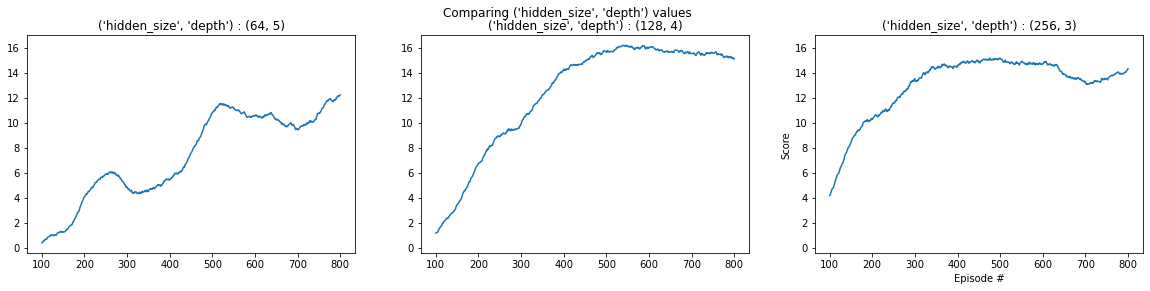

dropout : 0.0
Episode 0100 Score: 2.0 Average score over 100 episodes: 0.6500
Episode 0200 Score: 4.0 Average score over 100 episodes: 3.8300
Episode 0300 Score: 9.0 Average score over 100 episodes: 6.5200
Episode 0400 Score: 6.0 Average score over 100 episodes: 8.0700
Episode 0500 Score: 13.0 Average score over 100 episodes: 9.7600
Episode 0600 Score: 3.0 Average score over 100 episodes: 11.0400
Episode 0700 Score: 15.0 Average score over 100 episodes: 11.4700
Episode 0800 Score: 14.0 Average score over 100 episodes: 11.2100
Solved in Episode None
dropout : 0.2
Episode 0100 Score: 4.0 Average score over 100 episodes: 0.8400
Episode 0200 Score: 5.0 Average score over 100 episodes: 5.5400
Episode 0300 Score: 5.0 Average score over 100 episodes: 10.2100
Episode 0400 Score: 13.0 Average score over 100 episodes: 14.1000
Episode 0500 Score: 16.0 Average score over 100 episodes: 14.2800
Episode 0600 Score: 13.0 Average score over 100 episodes: 14.5100
Episode 0700 Score: 16.0 Average score o

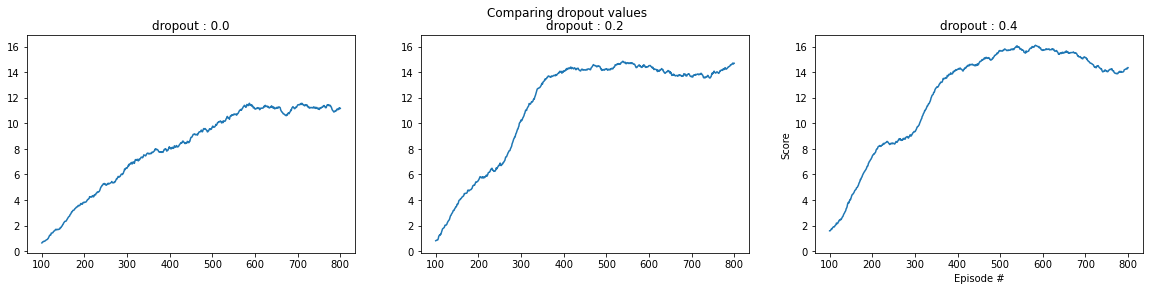

gamma : 0.999
Episode 0100 Score: 4.0 Average score over 100 episodes: 1.6000
Episode 0200 Score: 14.0 Average score over 100 episodes: 7.7900
Episode 0300 Score: 17.0 Average score over 100 episodes: 11.4800
Episode 0400 Score: 12.0 Average score over 100 episodes: 13.9400
Episode 0500 Score: 11.0 Average score over 100 episodes: 14.8800
Episode 0600 Score: 13.0 Average score over 100 episodes: 15.3900
Episode 0700 Score: 9.0 Average score over 100 episodes: 14.3200
Episode 0800 Score: 17.0 Average score over 100 episodes: 14.6300
Solved in Episode 336
gamma : 0.9999
Episode 0100 Score: 4.0 Average score over 100 episodes: 1.0900
Episode 0200 Score: 4.0 Average score over 100 episodes: 6.6200
Episode 0300 Score: 15.0 Average score over 100 episodes: 10.7700
Episode 0400 Score: 19.0 Average score over 100 episodes: 14.4700
Episode 0500 Score: 18.0 Average score over 100 episodes: 15.4700
Episode 0600 Score: 11.0 Average score over 100 episodes: 15.1700
Episode 0700 Score: 12.0 Average 

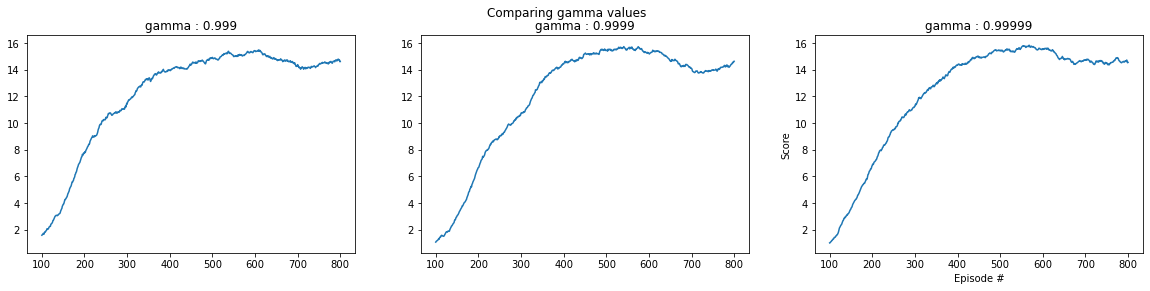

tau : 0.003
Episode 0100 Score: 2.0 Average score over 100 episodes: 1.6200
Episode 0200 Score: 8.0 Average score over 100 episodes: 5.7400
Episode 0300 Score: 13.0 Average score over 100 episodes: 10.7300
Episode 0400 Score: 17.0 Average score over 100 episodes: 12.7400
Episode 0500 Score: 12.0 Average score over 100 episodes: 13.8700
Episode 0600 Score: 16.0 Average score over 100 episodes: 13.9800
Episode 0700 Score: 14.0 Average score over 100 episodes: 14.1900
Episode 0800 Score: 15.0 Average score over 100 episodes: 13.9400
Solved in Episode 410
tau : 0.001
Episode 0100 Score: 1.0 Average score over 100 episodes: 1.3700
Episode 0200 Score: 16.0 Average score over 100 episodes: 6.9600
Episode 0300 Score: 6.0 Average score over 100 episodes: 10.3900
Episode 0400 Score: 13.0 Average score over 100 episodes: 13.4200
Episode 0500 Score: 14.0 Average score over 100 episodes: 14.8100
Episode 0600 Score: 16.0 Average score over 100 episodes: 15.6300
Episode 0700 Score: 12.0 Average score

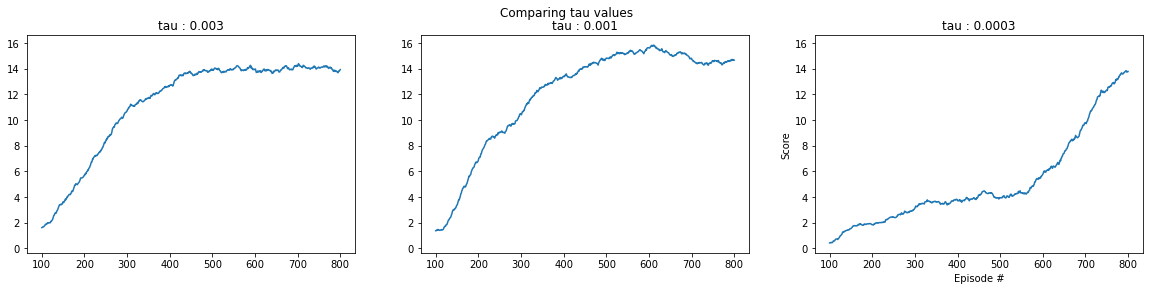

lr : 0.0001
Episode 0100 Score: 3.0 Average score over 100 episodes: 0.6900
Episode 0200 Score: 1.0 Average score over 100 episodes: 2.6300
Episode 0300 Score: 4.0 Average score over 100 episodes: 6.8000
Episode 0400 Score: 7.0 Average score over 100 episodes: 7.2000
Episode 0500 Score: 6.0 Average score over 100 episodes: 9.4100
Episode 0600 Score: 7.0 Average score over 100 episodes: 12.0700
Episode 0700 Score: 12.0 Average score over 100 episodes: 13.1400
Episode 0800 Score: 11.0 Average score over 100 episodes: 13.5800
Solved in Episode 686
lr : 0.0003
Episode 0100 Score: 3.0 Average score over 100 episodes: 1.8300
Episode 0200 Score: 15.0 Average score over 100 episodes: 7.8300
Episode 0300 Score: 15.0 Average score over 100 episodes: 11.4400
Episode 0400 Score: 11.0 Average score over 100 episodes: 13.7300
Episode 0500 Score: 14.0 Average score over 100 episodes: 14.6300
Episode 0600 Score: 13.0 Average score over 100 episodes: 15.2700
Episode 0700 Score: 15.0 Average score over 

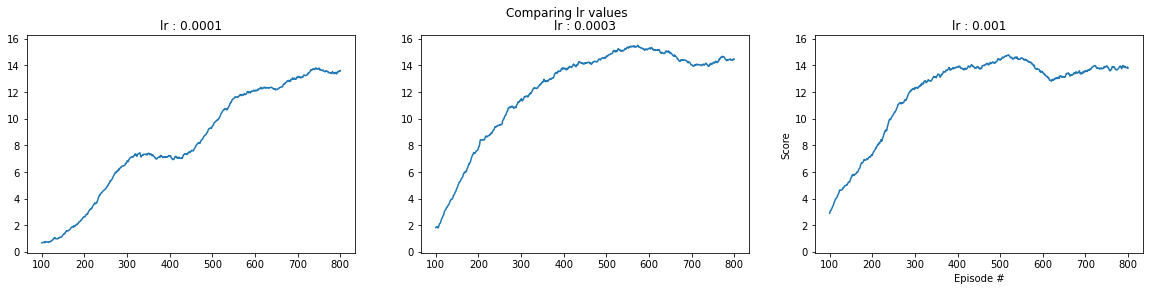

batch_size : 64
Episode 0100 Score: -2.0 Average score over 100 episodes: 0.1600
Episode 0200 Score: 3.0 Average score over 100 episodes: 2.0700
Episode 0300 Score: 0.0 Average score over 100 episodes: 5.1600
Episode 0400 Score: 11.0 Average score over 100 episodes: 7.1700
Episode 0500 Score: 10.0 Average score over 100 episodes: 8.7300
Episode 0600 Score: 10.0 Average score over 100 episodes: 10.5100
Episode 0700 Score: 15.0 Average score over 100 episodes: 11.7700
Episode 0800 Score: 18.0 Average score over 100 episodes: 12.8800
Solved in Episode None
batch_size : 256
Episode 0100 Score: 4.0 Average score over 100 episodes: 1.0700
Episode 0200 Score: 13.0 Average score over 100 episodes: 5.8600
Episode 0300 Score: 10.0 Average score over 100 episodes: 9.0200
Episode 0400 Score: 16.0 Average score over 100 episodes: 12.2100
Episode 0500 Score: 14.0 Average score over 100 episodes: 13.6700
Episode 0600 Score: 17.0 Average score over 100 episodes: 14.0800
Episode 0700 Score: 11.0 Averag

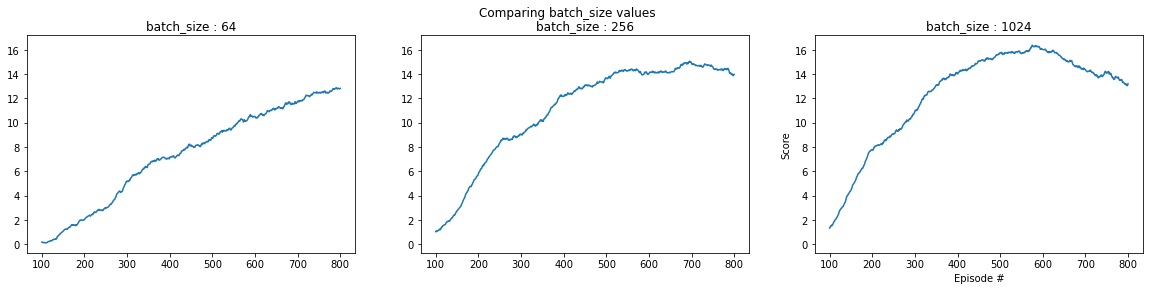

In [10]:
WINDOW = 100
NUM_EPISODES = 800

def smoothed_plot(hparam_key, scores_dict, window=WINDOW):
    axes = [None for i in range(len(scores_dict))]

    fig = plt.figure(figsize=(20,4))
    for i, (hparam_val, scores) in enumerate(scores_dict.items()):
        # sliding window average 
        smoothed_scores = [np.mean(scores[i-window+1:i]) for i in range(window-1, len(scores))]
        # plot the scores
        axes[i] = fig.add_subplot(1, len(scores_dict), i+1)
        # axes[i] = plt.subplot(1, len(scores_dict), i+1)
        axes[i].plot(window+np.arange(len(smoothed_scores)), smoothed_scores)
        axes[i].set_title(f'{hparam_key} : {hparam_val}')
    axes[0].get_shared_x_axes().join(axes[0], *axes[1:])
    axes[0].get_shared_y_axes().join(axes[0], *axes[1:])
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.suptitle(f'Comparing {hparam_key} values')
    plt.show()

for hparam_key, hparam_list in config_grid.items():
    # dict of scores by episode for each choice of hyperparameter
    scores_dict = {}
    for hparam_val in hparam_list:
        print(f"{hparam_key} : {hparam_val}")
        if type(hparam_key) == tuple:
            args = dict(zip(hparam_key, hparam_val))
        else:
            args = {hparam_key : hparam_val}
        agent = Agent(state_size=brain.vector_observation_space_size, 
                      action_size=brain.vector_action_space_size, 
                      **args)
        scores = []
        solved = None
        for episode in range(NUM_EPISODES):
            env_info = env.reset(train_mode=True)[brain_name] # reset the environment
            state = env_info.vector_observations[0]            # get the current state
            score = 0                                          # initialize the score
            while True:
                action = np.random.randint(action_size)        # select an action
                action = int(agent.act(state, eps=0.1))
                env_info = env.step(action)[brain_name]        # send the action to the environment
                next_state = env_info.vector_observations[0]   # get the next state
                reward = env_info.rewards[0]                   # get the reward
                done = env_info.local_done[0]                  # see if episode has finished
                agent.step(state, action, reward, next_state, done)
                score += reward                                # update the score
                state = next_state                             # roll over the state to next time step
                if done:                                       # exit loop if episode finished
                    break
            scores.append(score)
            if (episode+1 >= WINDOW and (episode+1) % WINDOW == 0) or episode+1 == NUM_EPISODES:
                print(f"Episode {episode+1:04d} Score: {score} Average score over {WINDOW} episodes: {np.array(scores[-WINDOW:]).mean():.4f}")
            if len(scores) > WINDOW and (np.array(scores[-WINDOW:]).mean() > 13) and not solved:
                solved = episode
        print("Solved in Episode {}".format(solved))
        
        scores_dict[hparam_val] = scores
    smoothed_plot(hparam_key, scores_dict)

In [11]:
agent = Agent(state_size=brain.vector_observation_space_size, action_size=brain.vector_action_space_size, 
              hidden_size=128, depth=4, dropout=0.4, batch_size=1024, gamma=0.9999, tau=1e-3, lr=3e-4, seed=42)
NUM_EPISODES = 2500
scores = []
solved = None
for episode in range(NUM_EPISODES):
    env_info = env.reset(train_mode=True)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0                                          # initialize the score
    while True:
        action = np.random.randint(action_size)        # select an action
        action = int(agent.act(state, eps=0.1))
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        agent.step(state, action, reward, next_state, done)
        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step
        if done:                                       # exit loop if episode finished
            break
    scores.append(score)
    if (episode+1) % 50 == 0 or episode+1 == NUM_EPISODES:
        print("Episode {:04d} Score: {} Average score: {:.4f}".format(episode+1, score, np.array(scores[-100:]).mean()))
    if len(scores) > 100 and (np.array(scores[-100:]).mean() > 13) and not solved:
        solved = episode
print("Solved in Episode {}".format(solved))
torch.save(agent.qnetwork_local.state_dict(), 'p1_agent_qnetwork_local.pt')

Episode 0050 Score: 0.0 Average score: 0.8400
Episode 0100 Score: 2.0 Average score: 1.2400
Episode 0150 Score: 8.0 Average score: 3.5700
Episode 0200 Score: 10.0 Average score: 6.8100
Episode 0250 Score: 5.0 Average score: 8.1500
Episode 0300 Score: 12.0 Average score: 9.3500
Episode 0350 Score: 14.0 Average score: 11.6800
Episode 0400 Score: 10.0 Average score: 13.2500
Episode 0450 Score: 15.0 Average score: 13.6700
Episode 0500 Score: 16.0 Average score: 14.3100
Episode 0550 Score: 14.0 Average score: 14.7300
Episode 0600 Score: 15.0 Average score: 15.0900
Episode 0650 Score: 15.0 Average score: 15.1600
Episode 0700 Score: 9.0 Average score: 14.4600
Episode 0750 Score: 10.0 Average score: 14.5100
Episode 0800 Score: 12.0 Average score: 14.4200
Episode 0850 Score: 5.0 Average score: 13.7500
Episode 0900 Score: 18.0 Average score: 14.1200
Episode 0950 Score: 17.0 Average score: 14.6700
Episode 1000 Score: 13.0 Average score: 14.5300
Episode 1050 Score: 17.0 Average score: 14.9400
Epis

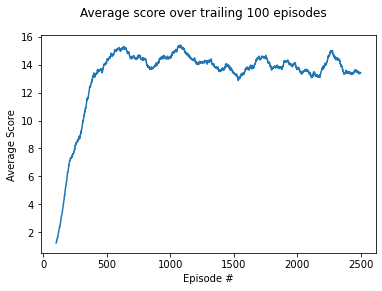

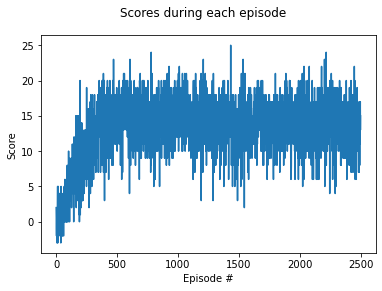

In [12]:
# sliding window average 
smoothed_scores = [np.mean(scores[i-99:i]) for i in range(99, len(scores))]
# plot the sliding window averaged scores
plt.plot(100+np.arange(len(smoothed_scores)), smoothed_scores)
plt.ylabel('Average Score')
plt.xlabel('Episode #')
plt.suptitle(f'Average score over trailing 100 episodes')
plt.show()

plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.suptitle(f'Scores during each episode')
plt.show()

### Load trained model

Here, you can load the pre-trained weights to observe the trained agent's policy in the environment.

In [13]:
agent = Agent(state_size=brain.vector_observation_space_size, action_size=brain.vector_action_space_size, seed=42)
agent.qnetwork_local.load_state_dict(torch.load('p1_agent_qnetwork_local.pt', map_location="cuda:0" if torch.cuda.is_available() else "cpu"))

In [14]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    action = int(agent.act(state, eps=0.1))
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    agent.step(state, action, reward, next_state, done)
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
print("Score: {}".format(score))

Score: 16.0


## Shut down the Environment

When you are done, run the following code block to close the Unity environment.

In [15]:
env.close()